In [2]:
import pandas as pd
import numpy as np


In [47]:
df = pd.read_csv("RLDataForCL60.csv",sep=';', parse_dates=[0])

In [50]:
df.head()

,UTC0,Input0,134_0,76_0,125_0 (Info_to_ignore: TickSize: 0.01 PointValue: 1000)
0,2019-01-04 11:00:00,48.69,0.478261,71.577411,2.311410
1,2019-01-04 12:00:00,48.88,0.434783,73.889657,2.710653
2,2019-01-04 13:00:00,48.63,0.391304,66.252309,2.185333
3,2019-01-04 13:47:00,48.79,0.357246,68.496609,2.521538
4,2019-01-04 14:29:00,48.83,0.326812,69.050739,2.605589


In [49]:
df.dtypes

UTC0                                                       datetime64[ns]
Input0                                                            float64
134_0                                                             float64
76_0                                                              float64
125_0 (Info_to_ignore: TickSize: 0.01 PointValue: 1000)           float64
dtype: object

Or use directly numpy as dates are not needed

In [41]:
data = np.genfromtxt("RLDataForCL60.csv",delimiter=';',skip_header=1,  dtype="float_")[:,1:]  # or  use usecols=(1,2,3,..) and no [:,1:]

In [52]:
data[0:5]

array([[48.69      ,  0.47826087, 71.57741085,  2.31140996],
       [48.88      ,  0.43478261, 73.88965726,  2.7106535 ],
       [48.63      ,  0.39130435, 66.25230913,  2.18533305],
       [48.79      ,  0.35724638, 68.49660906,  2.52153814],
       [48.83      ,  0.32681159, 69.05073924,  2.60558941]])

Scaling next, price not! which is used to calculate reward not a feature, if feature add separately MLIndicatorI 13 = Close
Sacling can be other too like [-1 - 1] 

In [68]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.1, 1))


In [69]:
features = data[:,1:] # price removed, column 1

In [70]:
scaler.fit(features)   # this need to be put to Dim 2 not to dim 3 values next
scaledFeatures = scaler.transform(features)

In [71]:
scaledFeatures[0:5]  # just head

array([[0.54864048, 0.87527158, 0.71767151],
       [0.50785498, 0.90803152, 0.75684043],
       [0.46706949, 0.79982548, 0.70530238],
       [0.43512085, 0.83162275, 0.73828673],
       [0.406571  , 0.83947367, 0.74653282]])

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

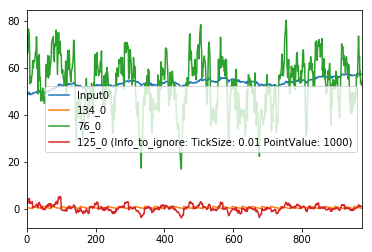

In [74]:
 df.plot();

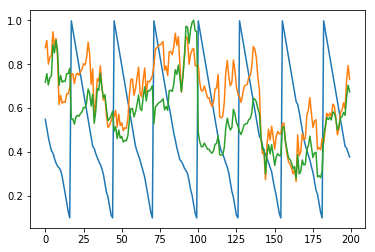

In [78]:
plt.plot(scaledFeatures[:200]) # part
plt.show()